First, let's import all necessary libraries:

In [1]:
import collections
import logging
import numpy as np
import os
import pytorch_lightning as pl
import torch

from copy import deepcopy
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.nn import BCEWithLogitsLoss
from tqdm.notebook import tqdm


#os.chdir('..')

from attacks import influence_attack, anchoring_attack
from datamodules import GermanCreditDatamodule, CompasDatamodule, DrugConsumptionDatamodule
from fairness import FairnessLoss
from trainingmodule import BinaryClassifier

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

Now we create a **general attack function** that handles all different attack methods

In [20]:
def attack(dm, model, eps, method):
    if method in ['IAF', 'Koh et al']:
        # Create adversarial loss according to Mehrabi et al.
        bce_loss, fairness_loss = BCEWithLogitsLoss(), FairnessLoss(dm.get_sensitive_index())
        
        if method == 'IAF':
            adv_loss = lambda _model, X, y: (
                    bce_loss(_model(X), y.float()) + 1 * fairness_loss(X, *_model.get_params())
            )
        else: # method == 'Koh et al'
            adv_loss = lambda _model, X, y: bce_loss(_model(X), y.float())
        
        # Create new training pipeline to use in influence attack
        trainer = pl.Trainer(
            max_epochs=100,
            gpus=1 if torch.cuda.is_available() else 0,
            enable_model_summary=False,
            enable_progress_bar=False,
            log_every_n_steps=1,
            callbacks=[EarlyStopping(monitor="train_acc", mode="max", patience=10)]
        )

        poisoned_dataset = influence_attack(
            model=model,
            datamodule=dm,
            trainer=trainer,
            adv_loss=adv_loss,
            eps=eps,
            eta=0.01,
            attack_iters=100,
        )
    elif method in ['RAA', 'NRAA']:
        poisoned_dataset = anchoring_attack(
            D_c=dm.get_train_dataset(),
            sensitive_idx=dm.get_sensitive_index(),
            eps=eps,
            tau=0,
            sampling_method='random' if method == 'RAA' else 'non-random',
            attack_iters=1,
        )
    else:
        raise ValueError(f'Unknown attack {method}.')
    
    # Create deep copy of the original dataset and poison the copy
    dm = deepcopy(dm)
    dm.update_train_dataset(poisoned_dataset)

    return dm

and a **nested dictionary**, which is convinient to store results for multiple datasets and metrics:

In [3]:
def nested_dict():
   return collections.defaultdict(nested_dict)

results = nested_dict()

Finally, iterate over all possible combination of Figure 2 in Mehrabi et al.

In [21]:
# Create Datamodules for all datasets
german_credit_datamodule = GermanCreditDatamodule('data/', 10)
compas_datamodule = CompasDatamodule('data/', 50)
drug_consumption_datamodule = DrugConsumptionDatamodule('data/', 10)


for dm in [german_credit_datamodule, compas_datamodule, drug_consumption_datamodule]:
    for method in ['IAF', 'RAA', 'NRAA', 'Koh et al']:
        print(f'Poisoning {dm.get_dataset_name()} dataset with {method} attack:')
        for eps in tqdm(np.arange(0, 1.1, 0.1)):
            # Create a Binary Classifier model for each dataset

            model = BinaryClassifier('LogisticRegression', dm.get_input_size(), lr=1e-3)
            print(f"\tEpsilon: {eps}")

            # Create poisoned dataset
            if eps == 0:
                dm_poisoned = dm
            else:
                dm_poisoned = attack(dm, model, eps, method)

            # Crate trainer
            trainer = pl.Trainer(
                max_epochs=300,
                gpus=1 if torch.cuda.is_available() else 0,
                enable_model_summary=False,
                enable_progress_bar=True,
                log_every_n_steps=1,
                callbacks=[EarlyStopping(monitor="train_acc", mode="max", patience=10)]
            )
            
            # Train on the poisoned dataset
            trainer.fit(model, dm_poisoned)
            
            # Save Accuracy and Fairness metrics
            metrics = trainer.test(model, dm)[0]
            results[dm.get_dataset_name()]['Test Error'][method][eps] = metrics['test_error']
            results[dm.get_dataset_name()]['Statistical Parity'][method][eps] = metrics['SPD']
            results[dm.get_dataset_name()]['Equality of Opportunity'][method][eps] = metrics['EOD']


Poisoning German Credit dataset with Koh et al attack:


  0%|          | 0/11 [00:00<?, ?it/s]

	Epsilon: 0.0


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.10972219705581665,
 'SPD': 0.15172414481639862,
 'test_error': 0.2250000238418579}
--------------------------------------------------------------------------------
	Epsilon: 0.1


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_248/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.07777780294418335,
 'SPD': 0.11034482717514038,
 'test_error': 0.2850000262260437}
--------------------------------------------------------------------------------
	Epsilon: 0.2


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_250/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.05972224101424217,
 'SPD': 0.18244510889053345,
 'test_error': 0.33000001311302185}
--------------------------------------------------------------------------------
	Epsilon: 0.30000000000000004


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_252/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.12222224473953247,
 'SPD': 0.008150458335876465,
 'test_error': 0.23000001907348633}
--------------------------------------------------------------------------------
	Epsilon: 0.4


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_254/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.02916663885116577,
 'SPD': 0.07460814714431763,
 'test_error': 0.23000001907348633}
--------------------------------------------------------------------------------
	Epsilon: 0.5


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_256/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.08194446563720703,
 'SPD': 0.08965519070625305,
 'test_error': 0.25999999046325684}
--------------------------------------------------------------------------------
	Epsilon: 0.6000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_258/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.0694444477558136,
 'SPD': 0.028213171288371086,
 'test_error': 0.3199999928474426}
--------------------------------------------------------------------------------
	Epsilon: 0.7000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_260/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.02916663885116577,
 'SPD': 0.023824453353881836,
 'test_error': 0.26499998569488525}
--------------------------------------------------------------------------------
	Epsilon: 0.8


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_262/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.043055564165115356, 'SPD': 0.07899686694145203, 'test_error': 0.625}
--------------------------------------------------------------------------------
	Epsilon: 0.9


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_264/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.1499999761581421,
 'SPD': 0.16677115857601166,
 'test_error': 0.2850000262260437}
--------------------------------------------------------------------------------
	Epsilon: 1.0


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_266/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.07777780294418335,
 'SPD': 0.09655171632766724,
 'test_error': 0.29500001668930054}
--------------------------------------------------------------------------------
Poisoning COMPAS dataset with Koh et al attack:


  0%|          | 0/11 [00:00<?, ?it/s]

	Epsilon: 0.0


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.3428853750228882,
 'SPD': 0.290578156709671,
 'test_error': 0.35318559408187866}
--------------------------------------------------------------------------------
	Epsilon: 0.1


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_269/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.2766798138618469,
 'SPD': 0.2566433250904083,
 'test_error': 0.44736847281455994}
--------------------------------------------------------------------------------
	Epsilon: 0.2


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_271/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.13768114149570465,
 'SPD': 0.09361252188682556,
 'test_error': 0.5747922658920288}
--------------------------------------------------------------------------------
	Epsilon: 0.30000000000000004


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_273/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.12747037410736084,
 'SPD': 0.14779150485992432,
 'test_error': 0.569252073764801}
--------------------------------------------------------------------------------
	Epsilon: 0.4


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_275/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.15283265709877014,
 'SPD': 0.1568812131881714,
 'test_error': 0.5193905830383301}
--------------------------------------------------------------------------------
	Epsilon: 0.5


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_277/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.08498024940490723,
 'SPD': 0.10894154757261276,
 'test_error': 0.47229915857315063}
--------------------------------------------------------------------------------
	Epsilon: 0.6000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_279/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.08003951609134674,
 'SPD': 0.11253255605697632,
 'test_error': 0.5678670406341553}
--------------------------------------------------------------------------------
	Epsilon: 0.7000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_281/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.054347842931747437,
 'SPD': 0.1026124581694603,
 'test_error': 0.5623269081115723}
--------------------------------------------------------------------------------
	Epsilon: 0.8


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_283/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.3863636255264282,
 'SPD': 0.31477242708206177,
 'test_error': 0.559556782245636}
--------------------------------------------------------------------------------
	Epsilon: 0.9


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_285/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.12812909483909607,
 'SPD': 0.07954037189483643,
 'test_error': 0.505540132522583}
--------------------------------------------------------------------------------
	Epsilon: 1.0


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_287/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.31455862522125244,
 'SPD': 0.25051620602607727,
 'test_error': 0.4335179924964905}
--------------------------------------------------------------------------------
Poisoning Drug Consumption dataset with Koh et al attack:


  0%|          | 0/11 [00:00<?, ?it/s]

	Epsilon: 0.0


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.33992668986320496,
 'SPD': 0.34838342666625977,
 'test_error': 0.33246758580207825}
--------------------------------------------------------------------------------
	Epsilon: 0.1


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_290/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.3641940951347351,
 'SPD': 0.38559937477111816,
 'test_error': 0.33506494760513306}
--------------------------------------------------------------------------------
	Epsilon: 0.2


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_292/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.4217948615550995,
 'SPD': 0.4381173253059387,
 'test_error': 0.33506494760513306}
--------------------------------------------------------------------------------
	Epsilon: 0.30000000000000004


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_294/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.31080588698387146,
 'SPD': 0.2413504719734192,
 'test_error': 0.350649356842041}
--------------------------------------------------------------------------------
	Epsilon: 0.4


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_296/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.06565934419631958,
 'SPD': 0.04104819893836975,
 'test_error': 0.5818182229995728}
--------------------------------------------------------------------------------
	Epsilon: 0.5


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_298/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.23498167097568512,
 'SPD': 0.2017865926027298,
 'test_error': 0.41038960218429565}
--------------------------------------------------------------------------------
	Epsilon: 0.6000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_300/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.44157513976097107,
 'SPD': 0.3929400146007538,
 'test_error': 0.5376623272895813}
--------------------------------------------------------------------------------
	Epsilon: 0.7000000000000001


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_302/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.19377288222312927,
 'SPD': 0.1434122920036316,
 'test_error': 0.41038960218429565}
--------------------------------------------------------------------------------
	Epsilon: 0.8


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_304/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.10467028617858887,
 'SPD': 0.0883035659790039,
 'test_error': 0.4155844449996948}
--------------------------------------------------------------------------------
	Epsilon: 0.9


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_306/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.0663919597864151,
 'SPD': 0.0668753981590271,
 'test_error': 0.5792207717895508}
--------------------------------------------------------------------------------
	Epsilon: 1.0


/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/dinos/code/FACT-AI/lightning_logs/version_308/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14970e3ee0>
Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/anaconda/envs/pytorchEnv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'EOD': 0.42032966017723083,
 'SPD': 0.396718293428421,
 'test_error': 0.4701298177242279}
--------------------------------------------------------------------------------


and plot results:

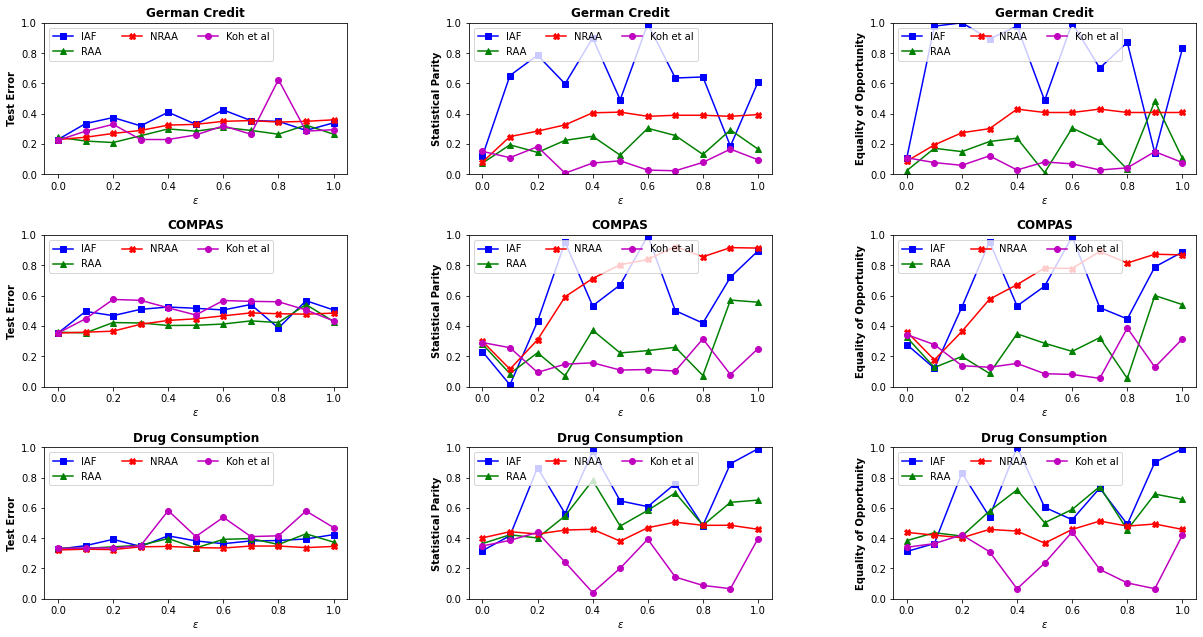

In [23]:
# Reproduce plot styling of the original paper
colors, markers = ['b', 'g', 'r', 'm'], ['s', '^', 'X', 'o']

fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for i, dataset in enumerate(['German Credit', 'COMPAS', 'Drug Consumption']):
    for j, metric in enumerate(['Test Error', 'Statistical Parity', 'Equality of Opportunity']):
        for k, method in enumerate(['IAF', 'RAA', 'NRAA', 'Koh et al']):
            ax[i, j].plot(
                list(results[dataset][metric][method].keys()),
                list(results[dataset][metric][method].values()),
                c=colors[k],
                marker=markers[k],
                label = method,
            )
        
        ax[i, j].set_xlabel('$\epsilon$', fontweight='bold')
        ax[i, j].set_ylabel(metric, fontweight='bold')
        ax[i, j].set_title(dataset, fontweight='bold')
        ax[i, j].legend(loc='upper left', ncol=3)
        ax[i, j].set_ylim([0, 1])
        
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)